%%latex
# Анализ объектов

Возьмите датасет вашего варианта из лабораторной работы № 1. Если вы раньше применяли бинаризацию целевого признака, то сейчас этого делать не нужно.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = 'bodyfat.csv'
data = pd.read_csv(file_path)

target = 'Neck'
n = 38
data['Neck_Binary'] = (data[target] <= n).astype(int)

bins = [0, 35, 41, np.inf]
labels = [0, 1, 2]
data['Neck_3'] = pd.cut(data['Neck'], bins=bins, labels=labels, right=False)

print(data.head())

   Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   Knee  Ankle  Biceps  Forearm  Wrist  Neck_Binary Neck_3  
0  37.3   21.9    32.0     27.4   17.1            1      1  
1  37.3   23.4    30.5     28.9   18.2            0      1  
2  38.9   24.0    28.8     25.2   16.6            1      0  
3  37.3   22.8    32.4     29.4   18.2            1      1  
4  42.2   24.0    32.2     27.7   17.7            1      0  


## Выступ (отступ)

Выступ - это такая функция M(x), что для объектов, лежащих глубоко внутри своего класса, т.е. для эталонов она принимает большие положительные значения. Для периферийных объектов, лежащих на границе классов, M(x)≈0. Для объектов одного класса, расположенных среди объектов другого класса, выступ M(x) должен принимать отрицательные значения. Так как границы классов зачастую нельзя четко определить, то объекты последнего типа с M(x)<0 делят на две подгруппы: ошибочные, для которых алгоритм не может четко определить границу между классами и ошибается (их может быть много, они граничат с периферийными) и случайные выбросы (outliers) - редкие непонятные объекты с M(x)<<0.

Для задачи классификации и некоторого алгоритма, возвращающего вероятности p(y|x) можно определить M для объекта x с правильным ответом y следующим образом: 

$$M(x) = p(y|x) - \max\limits_{s\neq y} p(s|x)$$

Для задачи регрессии можно в качестве выступа брать минус ошибку предсказания.

Возмите два алгоритма древовидный (ExtraTreesClassifier/Regressor или GradientBoostingClassifier/Regressor) и ближайших соседей (KNeighborsClassifier/Regressor). 

In [6]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Признаки и метки
X = data.drop(columns=['Neck_3', 'Neck_Binary', 'Neck'])  # убираем целевую и исходный Neck
y3 = data['Neck_3'].astype(int)
print(y3)
# Создаем модели с pipeline, чтобы стандартизировать признаки
clf_et = make_pipeline(StandardScaler(), ExtraTreesClassifier(random_state=42))
clf_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

0      1
1      1
2      0
3      1
4      0
      ..
247    0
248    1
249    1
250    1
251    1
Name: Neck_3, Length: 252, dtype: int32


С помощью cross_val_predict вычислите предсказания (для задачи склассификации - вероятности) и найдите выступы всех объектов. 

In [8]:
# Функция для вычисления выступов M(x)
def calculate_margin(clf, X, y):
    # Предсказания вероятностей с кросс-валидацией
    probas = cross_val_predict(clf, X, y, cv=5, method='predict_proba')
    margins = []
    for i, true_class in enumerate(y):
        p_y = probas[i, true_class]
        p_other_max = np.max(np.delete(probas[i], true_class))
        margin = p_y - p_other_max
        margins.append(margin)
    return np.array(margins)

margins_et = calculate_margin(clf_et, X, y3)
margins_knn = calculate_margin(clf_knn, X, y3)

# Выведем статистику по выступам
print("ExtraTreesClassifier margins:")
print(pd.Series(margins_et).describe())

print("\nKNeighborsClassifier margins:")
print(pd.Series(margins_knn).describe())

ExtraTreesClassifier margins:
count    252.000000
mean       0.559206
std        0.479861
min       -1.000000
25%        0.480000
50%        0.740000
75%        0.872500
max        1.000000
dtype: float64

KNeighborsClassifier margins:
count    252.000000
mean       0.558730
std        0.559349
min       -1.000000
25%        0.550000
50%        0.600000
75%        1.000000
max        1.000000
dtype: float64


Постройте на одном графике две кривые (для деревьев и KNN): зависимость выступа от номера объекта в отсортированном по выступам ряду объектов. 

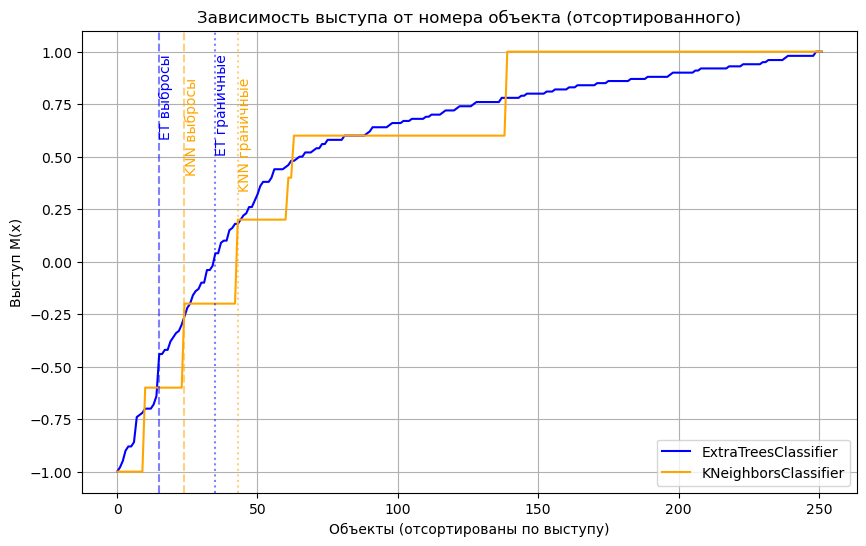

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Сортируем выступы отдельно для каждого алгоритма
sorted_margins_et = np.sort(margins_et)
sorted_margins_knn = np.sort(margins_knn)

# Создаем ось X — просто индекс отсортированных объектов
x = np.arange(len(sorted_margins_et))

plt.figure(figsize=(10,6))
plt.plot(x, sorted_margins_et, label='ExtraTreesClassifier', color='blue')
plt.plot(x, sorted_margins_knn, label='KNeighborsClassifier', color='orange')

plt.xlabel('Объекты (отсортированы по выступу)')
plt.ylabel('Выступ M(x)')
plt.title('Зависимость выступа от номера объекта (отсортированного)')
plt.legend()
plt.grid(True)


# Функция для поиска позиции, где выступ достигает порога
def find_threshold_index(margins, threshold):
    # Возвращаем индекс первого появления margin >= threshold (или len-1, если не найден)
    idxs = np.where(margins >= threshold)[0]
    return idxs[0] if len(idxs) > 0 else len(margins)-1

# Пороговые значения
outlier_threshold = -0.5
boundary_threshold = 0

# Для ExtraTreesClassifier
et_outlier_idx = find_threshold_index(sorted_margins_et, outlier_threshold)
et_boundary_idx = find_threshold_index(sorted_margins_et, boundary_threshold)

# Для KNeighborsClassifier
knn_outlier_idx = find_threshold_index(sorted_margins_knn, outlier_threshold)
knn_boundary_idx = find_threshold_index(sorted_margins_knn, boundary_threshold)

# Добавим линии для ExtraTrees
plt.axvline(et_outlier_idx, color='blue', linestyle='--', alpha=0.5)
plt.axvline(et_boundary_idx, color='blue', linestyle=':', alpha=0.5)

# Добавим линии для KNN
plt.axvline(knn_outlier_idx, color='orange', linestyle='--', alpha=0.5)
plt.axvline(knn_boundary_idx, color='orange', linestyle=':', alpha=0.5)

plt.text(et_outlier_idx, plt.ylim()[1]*0.9, 'ET выбросы', color='blue', rotation=90, va='top')
plt.text(et_boundary_idx, plt.ylim()[1]*0.9, 'ET граничные', color='blue', rotation=90, va='top')
plt.text(knn_outlier_idx, plt.ylim()[1]*0.8, 'KNN выбросы', color='orange', rotation=90, va='top')
plt.text(knn_boundary_idx, plt.ylim()[1]*0.8, 'KNN граничные', color='orange', rotation=90, va='top')

plt.show()

Выведите на экран 4 случайных выброса с разными значениями целевого признака и объясните эти аномалии в данных (20% баллов - за правильное объяснение). Вам помогут: важные признаки, найденные в предыдущей лаб. работе, и коэффициенты корреляции. ВАЖНО: выступ характеризует не "абстрактную" типичность объекта, а качество предсказания целевого признака!

In [12]:
import random

# Выберем индексы выбросов по ExtraTrees (margins_et < -0.5)
outlier_indices_et = np.where(margins_et < -0.5)[0]

# Получим DataFrame с информацией по выбросам
outliers_et = data.iloc[outlier_indices_et].copy()
outliers_et['Margin_ET'] = margins_et[outlier_indices_et]
outliers_et['Class'] = y3.iloc[outlier_indices_et]

# Возьмем 4 разных класса (если есть)
unique_classes = outliers_et['Class'].unique()

sampled_outliers = pd.DataFrame()

for cls in unique_classes:
    cls_outliers = outliers_et[outliers_et['Class'] == cls]
    if len(cls_outliers) > 0:
        sampled = cls_outliers.sample(1, random_state=42)
        sampled_outliers = pd.concat([sampled_outliers, sampled])
    if len(sampled_outliers) >= 4:
        break

# Если недостаточно уникальных классов, добираем случайных
if len(sampled_outliers) < 4:
    remain = 4 - len(sampled_outliers)
    remaining_samples = outliers_et.drop(sampled_outliers.index).sample(remain, random_state=42)
    sampled_outliers = pd.concat([sampled_outliers, remaining_samples])

# Выведем информацию по выбранным выбросам
with pd.option_context('display.max_columns', None):
    print(sampled_outliers)

# Визуальное пояснение
for idx, row in sampled_outliers.iterrows():
    print(f"\nОбъект с индексом {idx}, класс: {row['Class']}, выступ (ExtraTrees): {row['Margin_ET']:.3f}")
    print("Возможная причина аномалии:")
    print("- Низкий выступ говорит о том, что модель не уверена в предсказании данного объекта.")
    print("- Возможно, объект лежит на границе классов,")
    print("- или признаки объекта не типичны для его класса,")
    print("- либо имеются шумы или ошибки в данных.")
    print(f"Признаки объекта: Age={row['Age']}, Weight={row['Weight']}, Height={row['Height']}, BodyFat={data.loc[idx, 'BodyFat']:.1f}\n")


    

     Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  \
4     1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   
9     1.0722     11.7   23  198.25   73.50  42.1   99.6     88.6  104.1   
216   1.0678     13.6   51  149.25   69.75  34.8   92.8     81.1   96.3   
209   1.0742     10.8   47  159.75   70.75  34.5   92.9     84.4   94.0   

     Thigh  Knee  Ankle  Biceps  Forearm  Wrist  Neck_Binary Neck_3  \
4     63.2  42.2   24.0    32.2     27.7   17.7            1      0   
9     63.1  41.7   25.0    35.6     30.0   19.2            0      2   
216   53.8  36.5   21.5    31.3     26.3   17.8            1      0   
209   56.0  38.2   22.6    29.0     26.2   17.6            1      0   

     Margin_ET  Class  
4        -0.95      0  
9        -0.70      2  
216      -0.70      0  
209      -0.70      0  

Объект с индексом 4, класс: 0.0, выступ (ExtraTrees): -0.950
Возможная причина аномалии:
- Низкий выступ говорит о том, что модель не уверена в пре

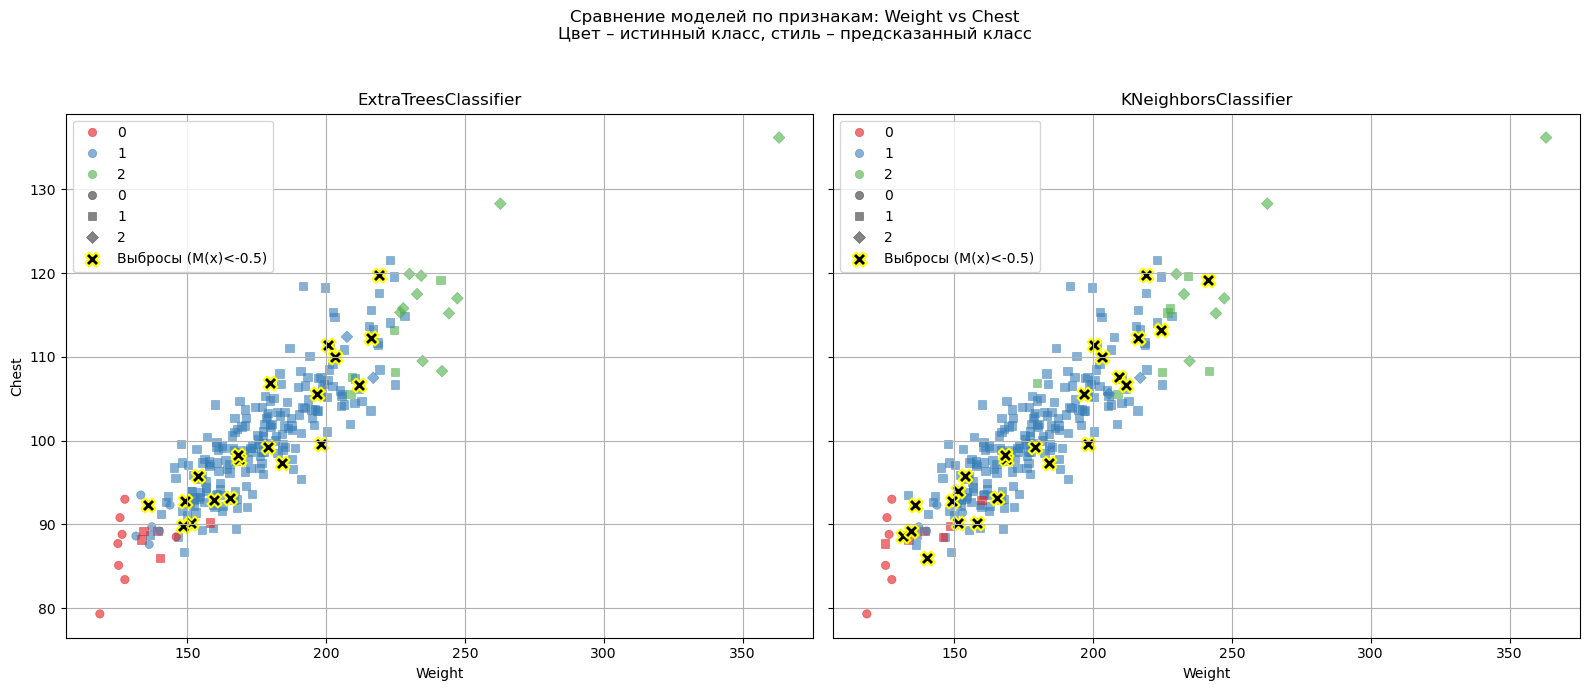

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
import numpy as np

def plot_2d_projection_two_models(data, feature_x, feature_y, margin_threshold=-0.5, random_state=42, target="Neck_3", default_target="Neck"):
    # Признаки для классификации (исключаем целевой и BodyFat)
    X = data.drop(columns=[target, default_target])
    y = data[target].astype(int)
    
    # Модели
    clf_et = make_pipeline(StandardScaler(), ExtraTreesClassifier(random_state=random_state))
    clf_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
    
    # ExtraTrees предсказания и вероятности
    y_pred_et = cross_val_predict(clf_et, X, y, cv=5, method='predict')
    y_probas_et = cross_val_predict(clf_et, X, y, cv=5, method='predict_proba')
    # Выступ для ET
    margins_et = np.array([p[y_i] - np.max(np.delete(p, y_i)) for p, y_i in zip(y_probas_et, y)])
    
    # KNN предсказания и вероятности
    y_pred_knn = cross_val_predict(clf_knn, X, y, cv=5, method='predict')
    y_probas_knn = cross_val_predict(clf_knn, X, y, cv=5, method='predict_proba')
    # Выступ для KNN
    margins_knn = np.array([p[y_i] - np.max(np.delete(p, y_i)) for p, y_i in zip(y_probas_knn, y)])
    
    # Индексы выбросов
    outlier_idx_et = np.where(margins_et < margin_threshold)[0]
    outlier_idx_knn = np.where(margins_knn < margin_threshold)[0]
    
    # Палитра для классов
    palette = sns.color_palette("Set1", n_colors=len(np.unique(y)))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
    
    # График для ExtraTrees
    sns.scatterplot(x=data[feature_x], y=data[feature_y], hue=y, palette=palette, style=y_pred_et,
                    markers=['o', 's', 'D'], alpha=0.6, edgecolor=None, legend='full', ax=axes[0])
    axes[0].scatter(data.iloc[outlier_idx_et][feature_x], data.iloc[outlier_idx_et][feature_y],
                    color='black', marker='X', s=100, label='Выбросы (M(x)<{})'.format(margin_threshold), edgecolor='yellow', linewidth=1.5)
    axes[0].set_title('ExtraTreesClassifier')
    axes[0].set_xlabel(feature_x)
    axes[0].set_ylabel(feature_y)
    axes[0].grid(True)
    axes[0].legend()
    
    # График для KNeighbors
    sns.scatterplot(x=data[feature_x], y=data[feature_y], hue=y, palette=palette, style=y_pred_knn,
                    markers=['o', 's', 'D'], alpha=0.6, edgecolor=None, legend='full', ax=axes[1])
    axes[1].scatter(data.iloc[outlier_idx_knn][feature_x], data.iloc[outlier_idx_knn][feature_y],
                    color='black', marker='X', s=100, label='Выбросы (M(x)<{})'.format(margin_threshold), edgecolor='yellow', linewidth=1.5)
    axes[1].set_title('KNeighborsClassifier')
    axes[1].set_xlabel(feature_x)
    axes[1].set_ylabel(feature_y)
    axes[1].grid(True)
    axes[1].legend()
    
    # Общий заголовок
    plt.suptitle(f'Сравнение моделей по признакам: {feature_x} vs {feature_y}\nЦвет – истинный класс, стиль – предсказанный класс')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Пример вызова функции:
plot_2d_projection_two_models(data, feature_x='Weight', feature_y='Chest')

* Если вы не увидели сгущения с помощью PCA, примените [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и нарисуйте аналогичный график рассеяния. Поймите и запишите в ответе физический смысл найденных сгущений данных (20% баллов). Это можно сделать, взяв наугад точки внутри кластеров в embadding (т.е. на графике рассеяния) и применив обратное преобразование. Другой хороший прием: строить графики рассеяния, перебирая в качестве цвета различные признаки. Нам нужны те, для которых сгущения красятся в разный цвет.

* Теперь наши сгущения требуется найти точно. Примените [один из методов кластеризации sklearn](https://scikit-learn.org/stable/modules/clustering.html) к нормализованной выборке со всеми признаками без целевого (или к выборке в embadding пространстве). Отобразите на двумерном графике рассеяния на главных компонентах (или в пространстве t-SNE) разным цветом получившиеся кластеры. Нужно так подобрать параметры алгоритма, чтобы он вернул те же кластеры, которые вы наблюдали в предыдущем пункте. При выборе алгоритма будьте внимательны: многие из них основаны на близости точек, а не на связанности кластеров, поэтому при применении к равномерно распределенной на квадрате выборке возвращают фиктивные кластеры. Я вам советую применять DBSCAN. Чтобы подобрать его параметр eps, для некоторого min_samples, постройте график отсортированных расстояний до ближайшего соседа № min_samples и найдите по нему 90% квантиль

Полезный код: вместо расчета плотности точек можно использовать расстояние до n-того соседа. Чтобы посчитать расстояния за разумное время лучше всего использовать пару функций:
```
d = scipy.spatial.distance.cdist(x, x)  # расчет расстояний от каждой точки выборки x до каждой (одна точка - одна строчка матрицы x)
r = np.partition(d, min_samples, axis=1)[:,min_samples]  # поиск min_samples минимальных элементов
```
Если цвета плотности почти всех точек совпадают, попробуйте логарифмировать r: `hue=np.log(r)`

На графике отсортированных расстояний до ближайшего соседа удобно включать логарифмический масштаб по оси y: `plt.yscale('log')`